In [237]:
import torch
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from PIL import Image
import torch.utils.data as data
from resnet_attention import resnet50
import matplotlib.pyplot as plt
import cv2


In [238]:
path_to_model = '/home/kpusteln/Fetal-RL/swin-transformer/output/resnet_50_melanoma_att/default/ckpt_epoch_3.pth'

In [239]:
model = resnet50(pretrained=False)
checkpoint1 = torch.load(path_to_model, map_location='cpu')
msg1 = model.load_state_dict(checkpoint1['model'], strict=False)

In [281]:
path_to_test_img = '/home/kpusteln/melanoma/train/train/ISIC_9000234.jpg'

In [308]:
img = Image.open(path_to_test_img)

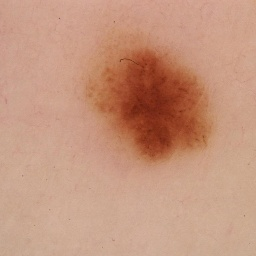

In [309]:
img

In [310]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Resize((256, 256)),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [311]:
img = t(img)

In [312]:
img = img.unsqueeze(0)

In [313]:
model.eval()
pred = model(img)

shape of A in gated attention: torch.Size([1, 2048, 1])


In [314]:
attention = pred[1][0][0]

In [315]:
pred

(tensor([[ 2.8360, -0.0315]], grad_fn=<AddmmBackward0>),
 tensor([[[4.8611e-04, 9.5537e-05, 1.0136e-03,  ..., 2.7789e-04,
           6.1226e-04, 5.4730e-05]]], grad_fn=<PermuteBackward0>))

In [316]:
pred[0][0][0].backward()

In [291]:
gradients = model.get_activations_gradient()

In [292]:
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

In [317]:
activations = model.extract_features(img).detach()

In [180]:
activations = activations*gradients

In [318]:
for i, att in enumerate(attention):
    activations[:, i, :, :] *= att

In [295]:
for i in range(2048):
    activations[:, i, :, :] *= pooled_gradients[i]

In [319]:
activations = activations.detach()

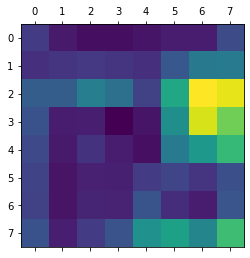

In [320]:
heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)
plt.matshow(heatmap.squeeze())

In [321]:
img = cv2.imread('/home/kpusteln/melanoma/train/train/ISIC_9000234.jpg')
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./grad_cam.jpg', superimposed_img)
cv2.imwrite('./clean.jpg', img)

True